<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/liver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1672, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1672 (delta 149), reused 118 (delta 60), pack-reused 1444 (from 1)
Receiving objects: 100% (1672/1672), 17.70 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (1132/1132), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.35% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
3.05% complete (down: 31270.3 kB/s up: 934.5 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="liver")
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

## Visualize

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor, image_root = None, label_root = None, bbox = None):
    """
    Visualize 3D volume (from DataLoader) using Max Intensity Projection (MIP)

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]

    Notes:
        - Converts to numpy
        - Projects to 2D using max projection along depth
    """
    if image_root is not None and label_root is not None:
      label_root_clone = resize_crop_to_bbox_size(label_tensor.squeeze(0), bbox)

    # Convert to numpy, squeeze to shape [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()

    # Max projection along depth
    image_2d = np.max(image, axis=0)
    label_2d = np.max(label, axis=0)

    if image_root is not None and label_root is not None:
        label_root_clone = uncrop_to_full_image(label_root_clone, bbox, label_root.squeeze().shape)
        label_root_clone = label_root_clone.detach().cpu().numpy().squeeze()

        image_root = image_root.detach().cpu().numpy().squeeze()
        label_root = label_root.detach().cpu().numpy().squeeze()

        image_root_2d = np.max(image_root, axis=0)
        label_root_2d = np.max(label_root, axis=0)
        label_root_clone_2d = np.max(label_root_clone, axis=0)
    # Color map for tumor mask
    cmap = mcolors.ListedColormap(["black", "yellow"])

    # Plotting
    num_cols = 2 if image_root is None and label_root is None else 5
    plt.figure(figsize=(5 * num_cols, 5))

    plt.subplot(1, num_cols, 1)
    plt.title("Input Image ")
    plt.imshow(image_2d, cmap='gray')
    plt.axis("off")

    plt.subplot(1, num_cols, 2)
    plt.title("Ground Truth (Liver)")
    plt.imshow(image_2d, cmap='gray')
    plt.imshow(label_2d, cmap=cmap, alpha=0.5)
    plt.axis("off")

    if num_cols > 2:
          plt.subplot(1, num_cols, 3)
          plt.title("Input Image ")
          plt.imshow(image_root_2d, cmap='gray')
          plt.axis("off")

          plt.subplot(1, num_cols, 4)
          plt.title("Ground Truth (Liver)")
          plt.imshow(image_root_2d, cmap='gray')
          plt.imshow(label_root_2d, cmap=cmap, alpha=0.5)
          plt.axis("off")

          plt.subplot(1, num_cols, 5)
          plt.title("Ground Truth (Liver) resize from liver crop")
          plt.imshow(image_root_2d, cmap='gray')
          plt.imshow(label_root_clone_2d, cmap=cmap, alpha=0.5)
          plt.axis("off")

    plt.tight_layout()
    plt.show()


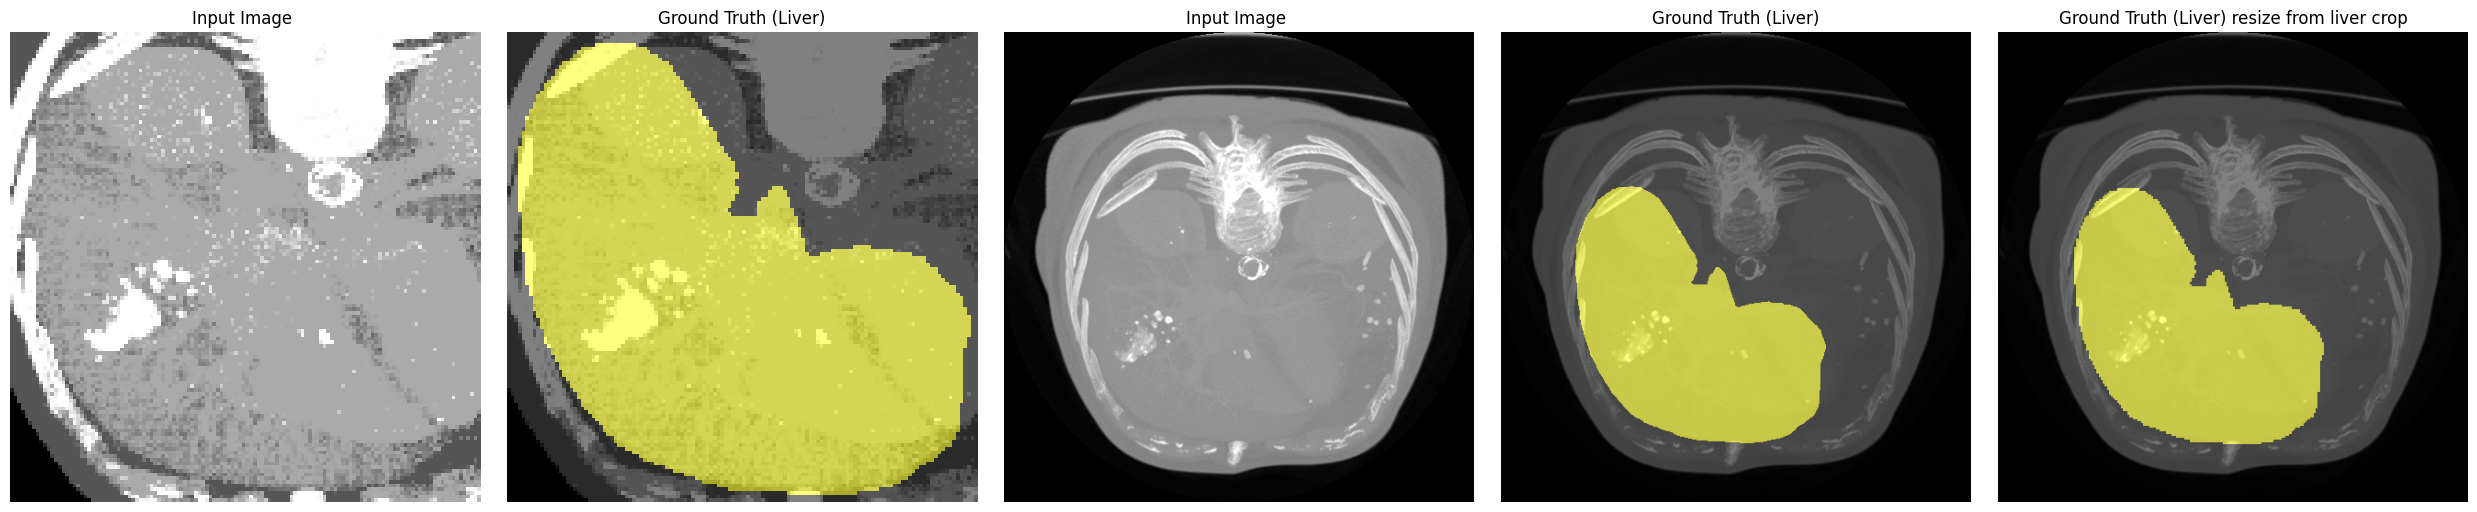

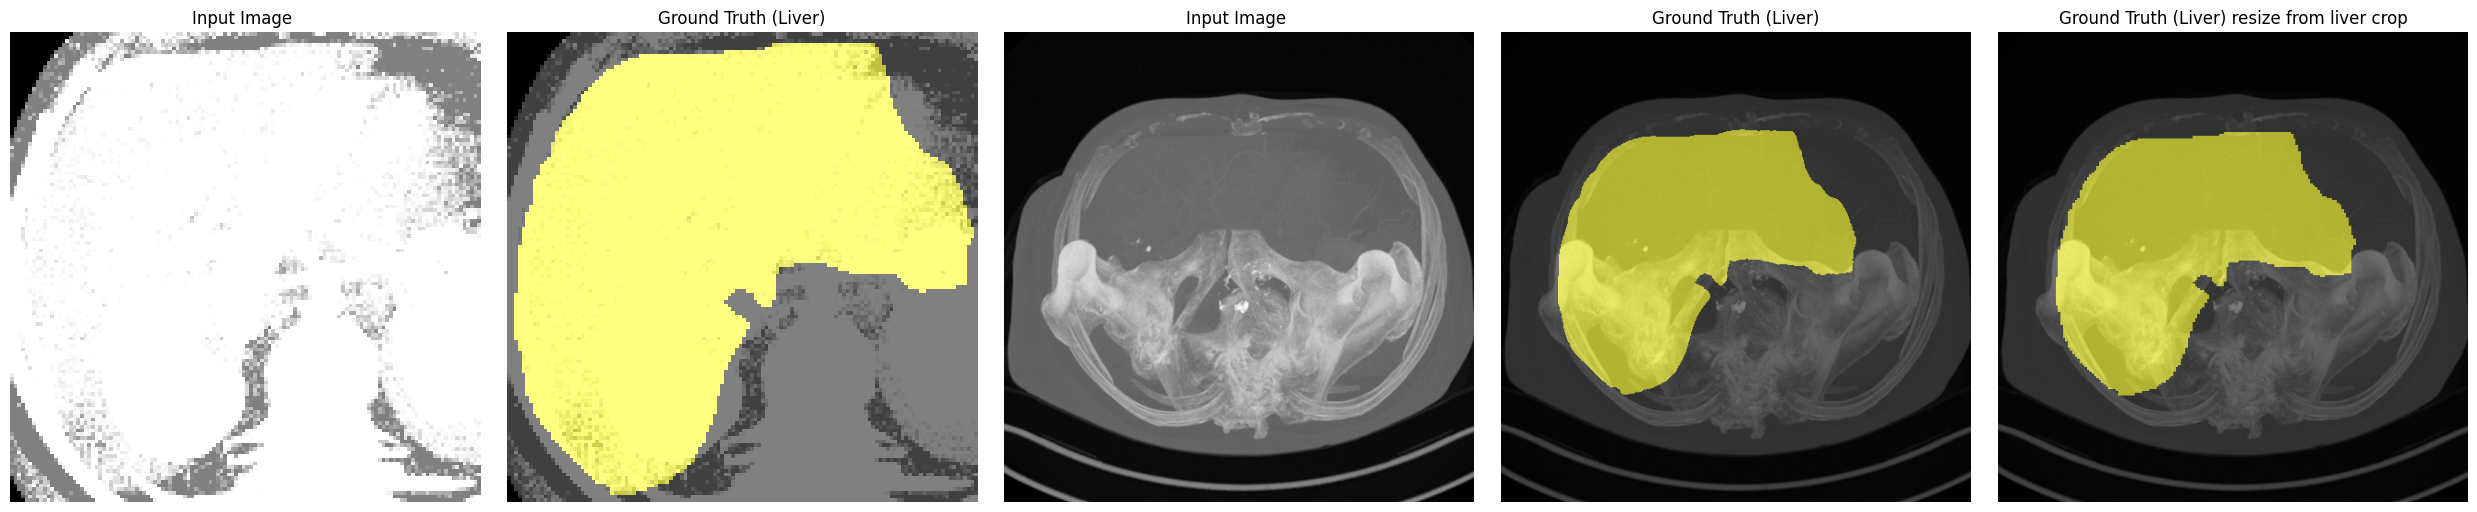

In [18]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]
    image_root = train_data["root_image"]
    label_root = train_data["root_label"]
    bbox = train_data["bbox"]
    visualize_from_loader(image, label, image_root, label_root, bbox)
    if i == 2:
      break

## Training

In [8]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [9]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver"
)

In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor.pth']


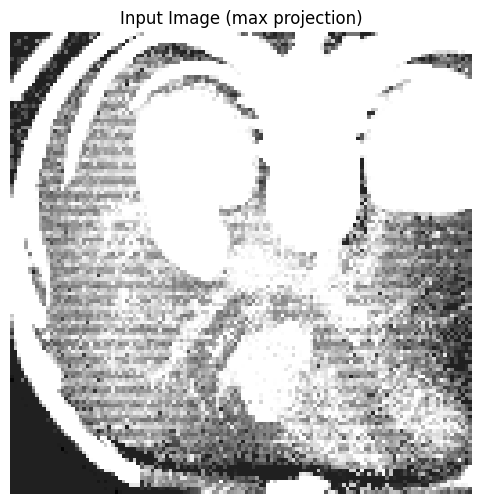

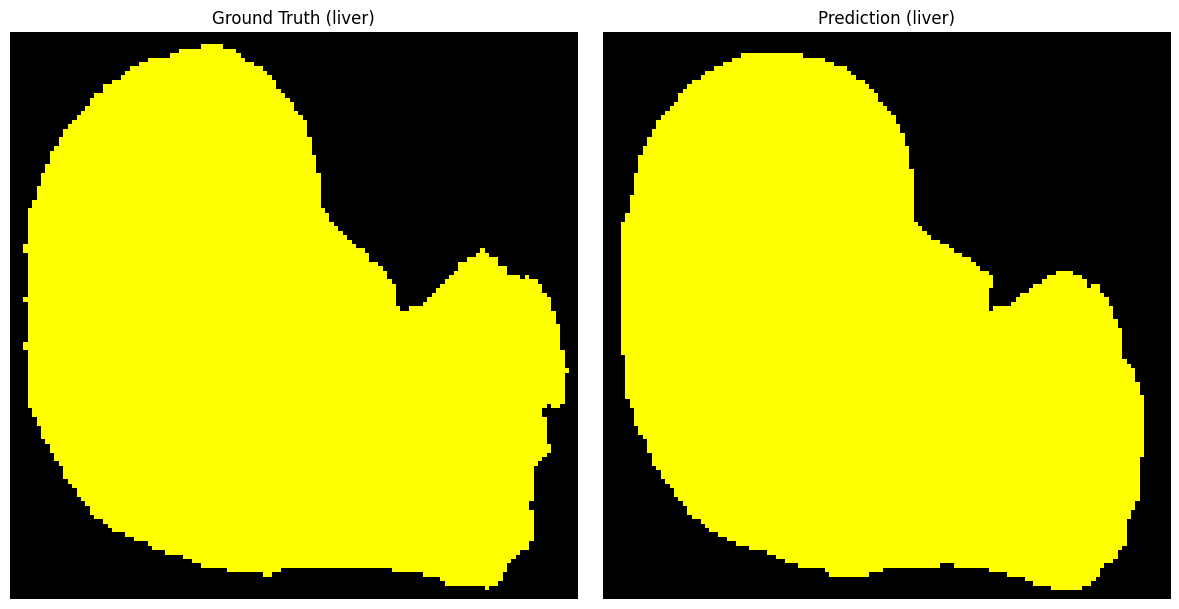

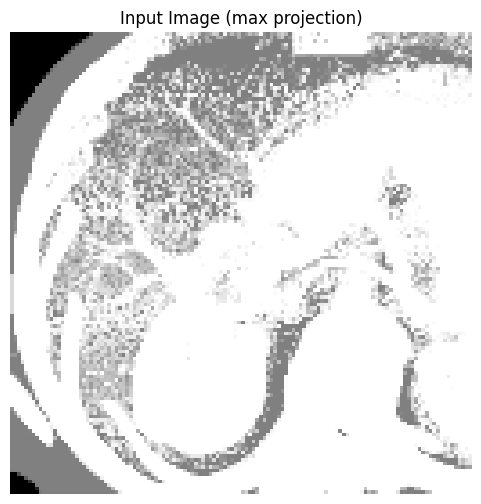

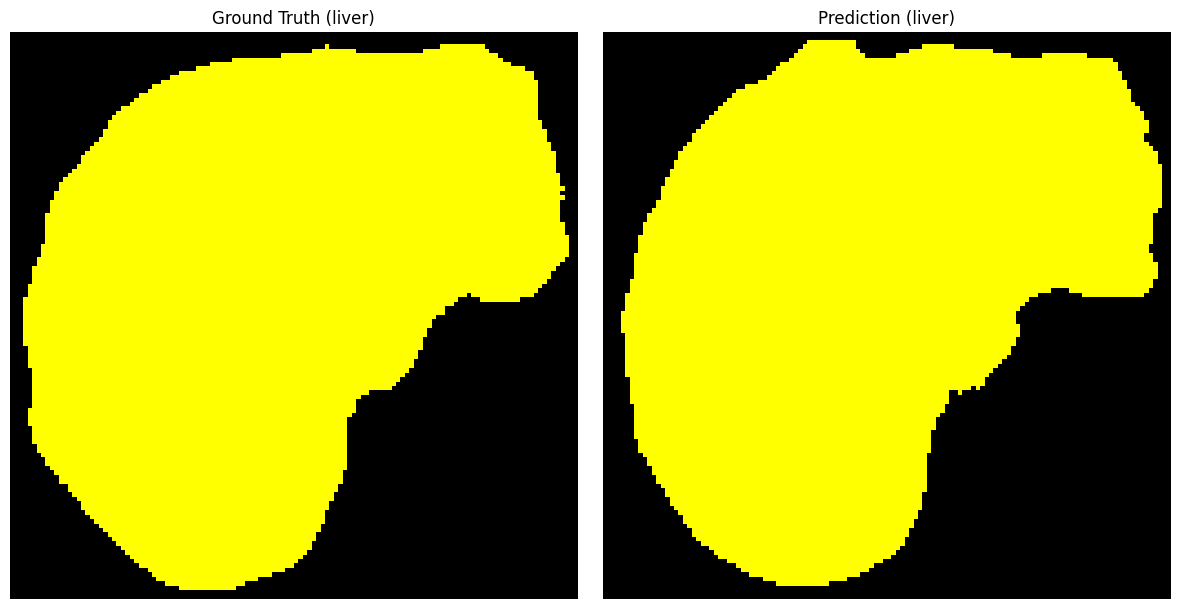

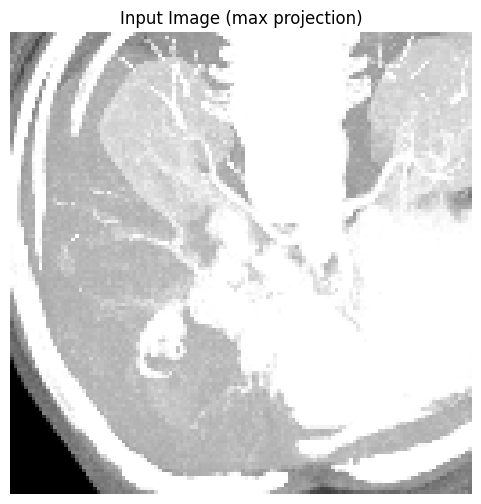

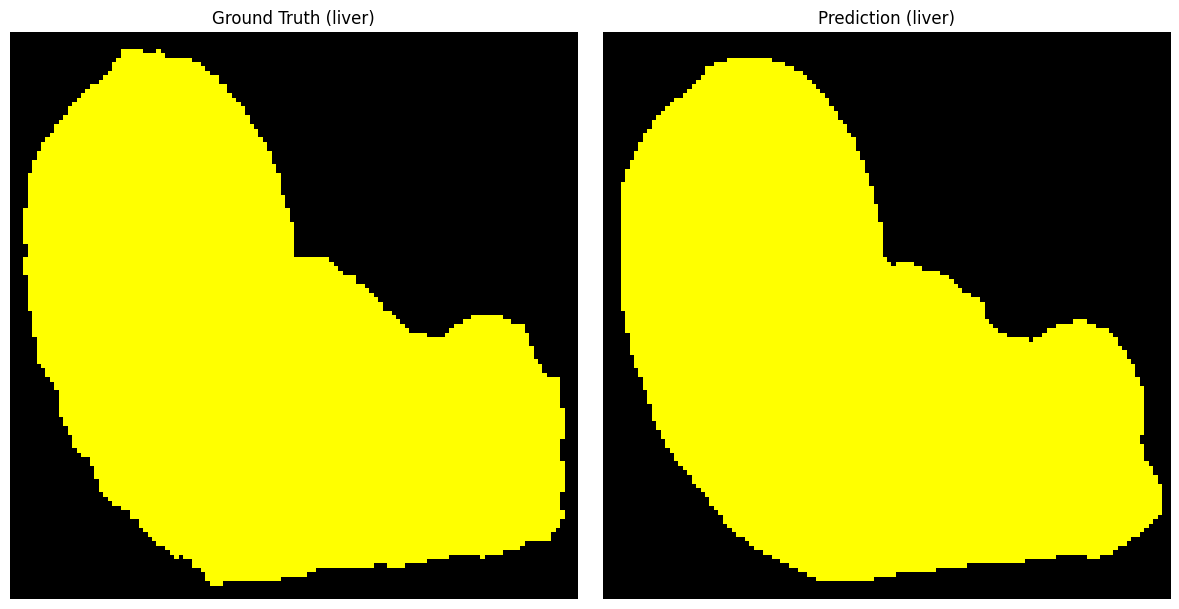

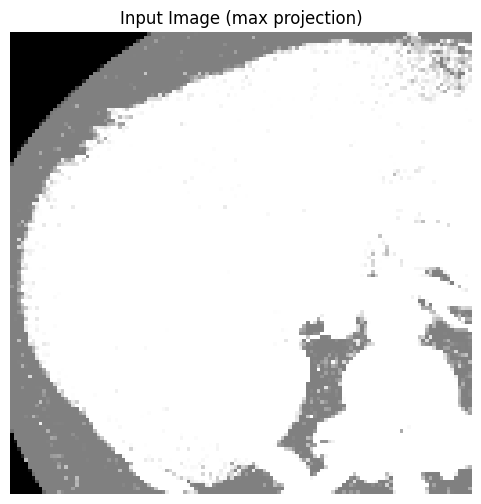

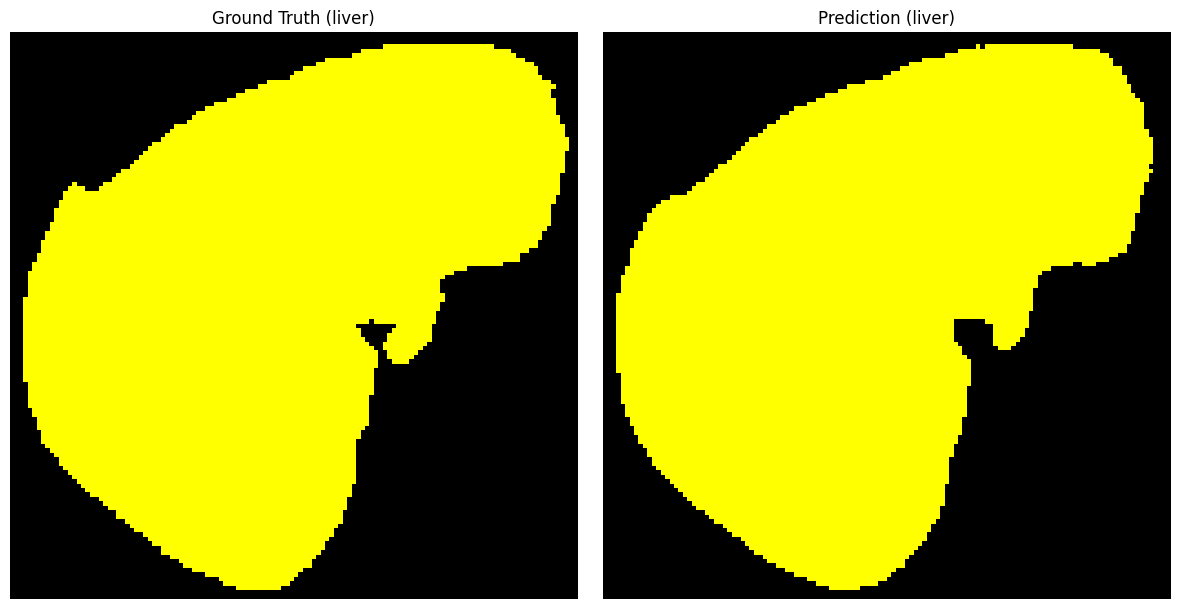

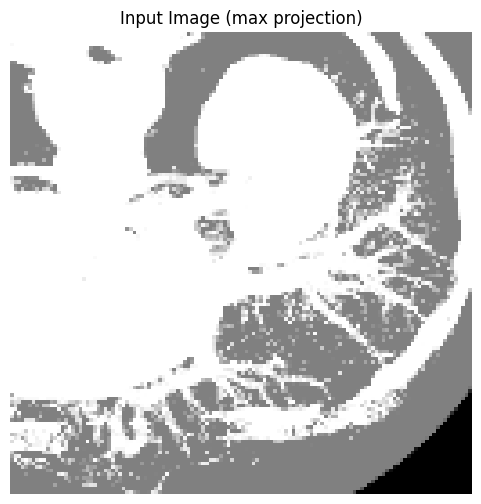

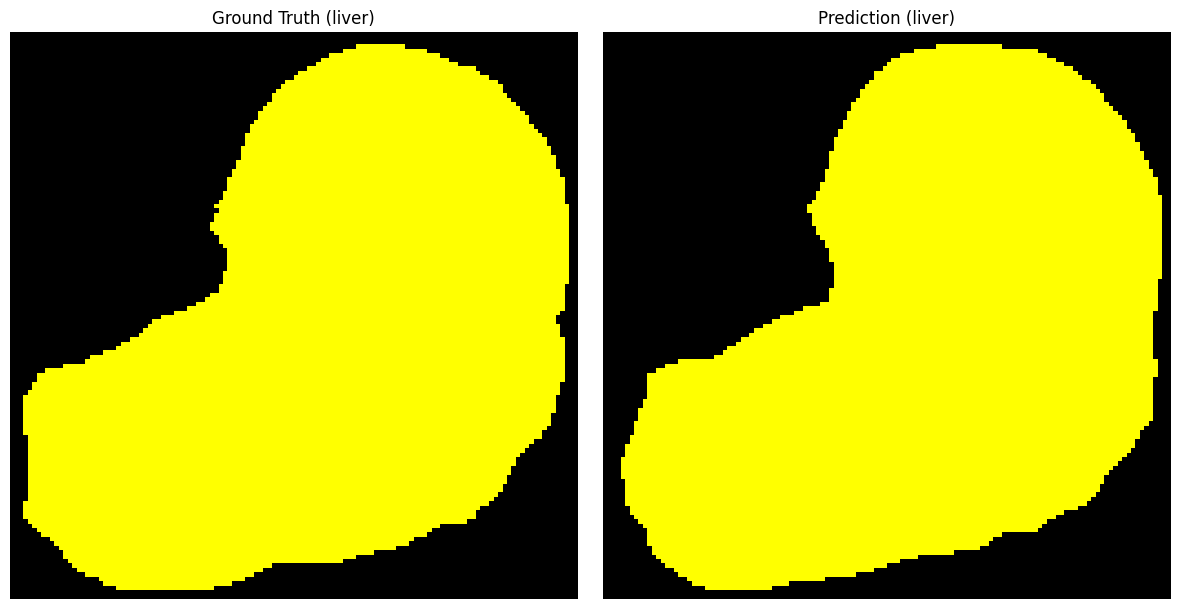

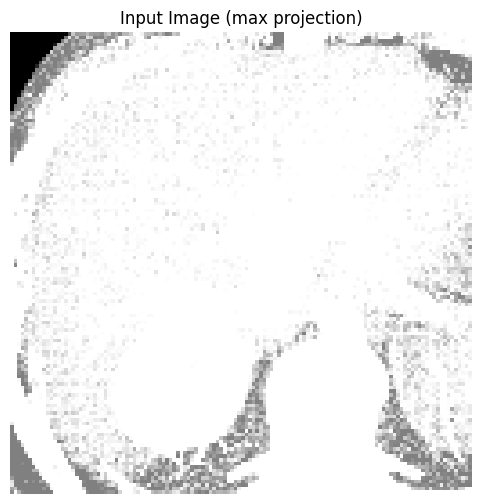

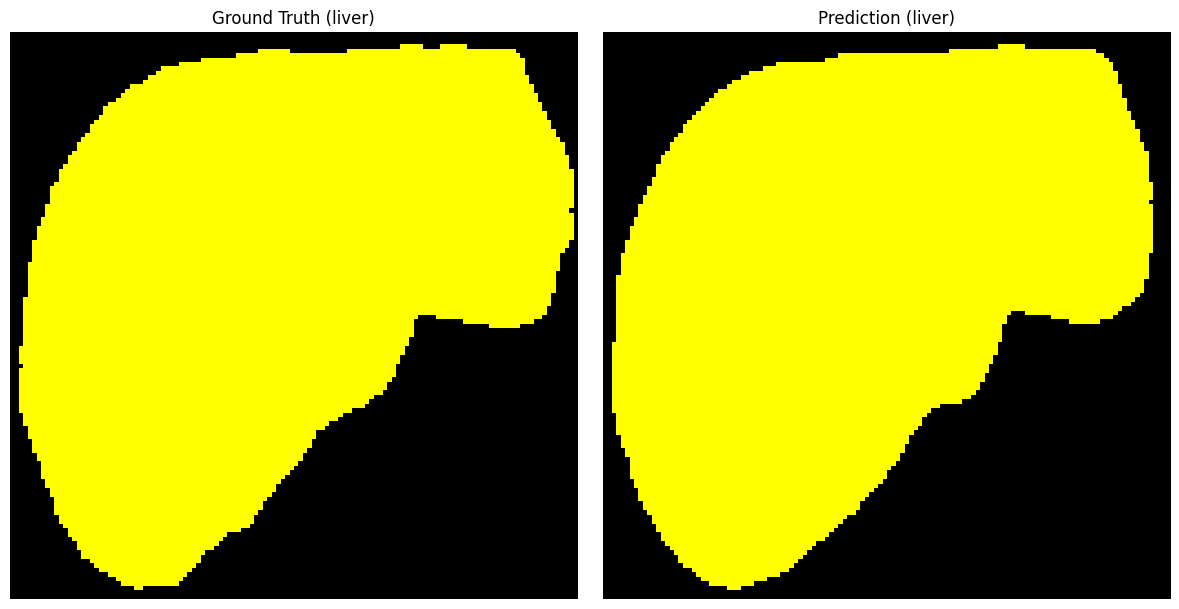

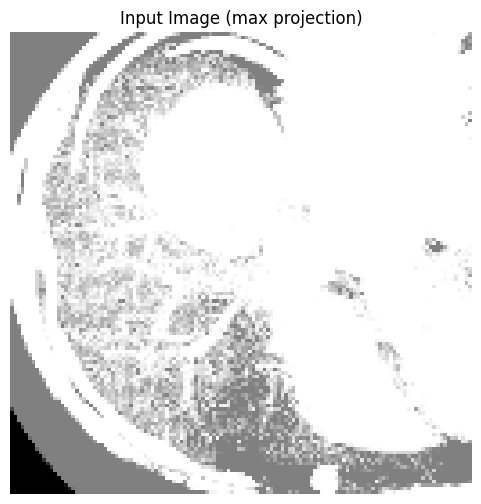

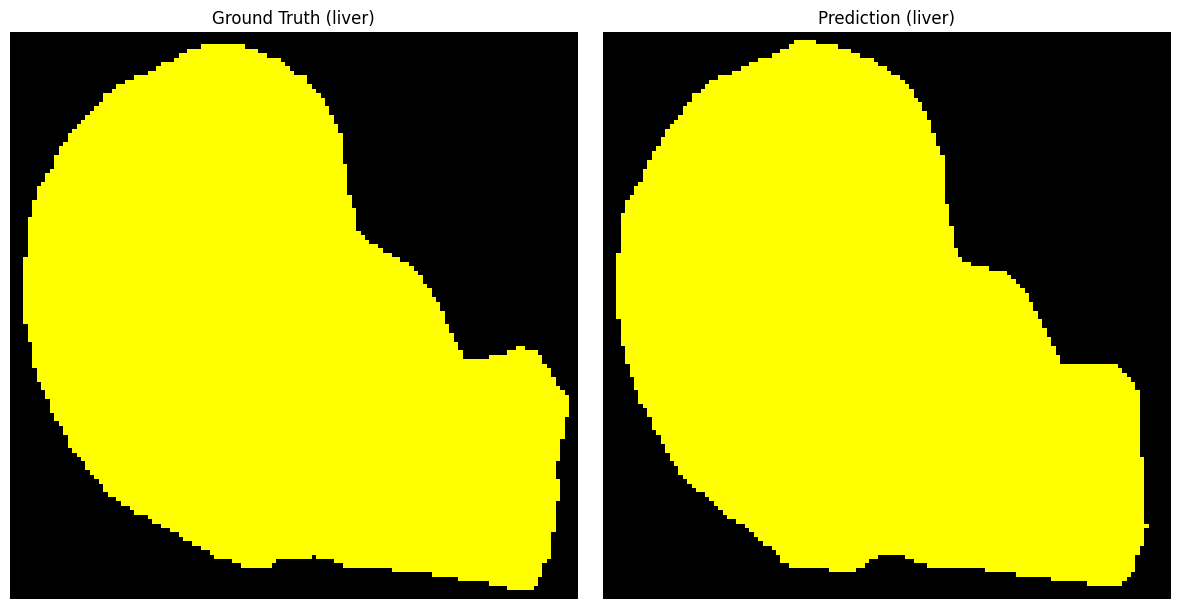

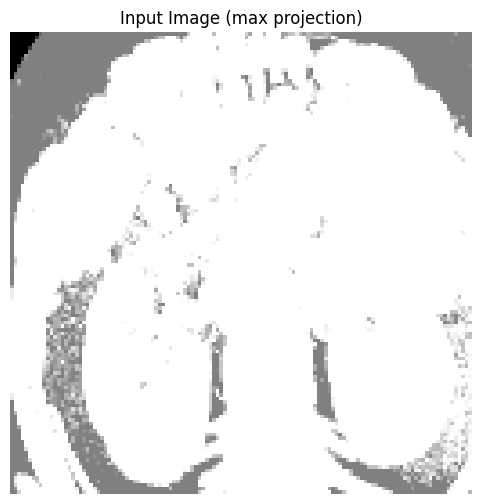

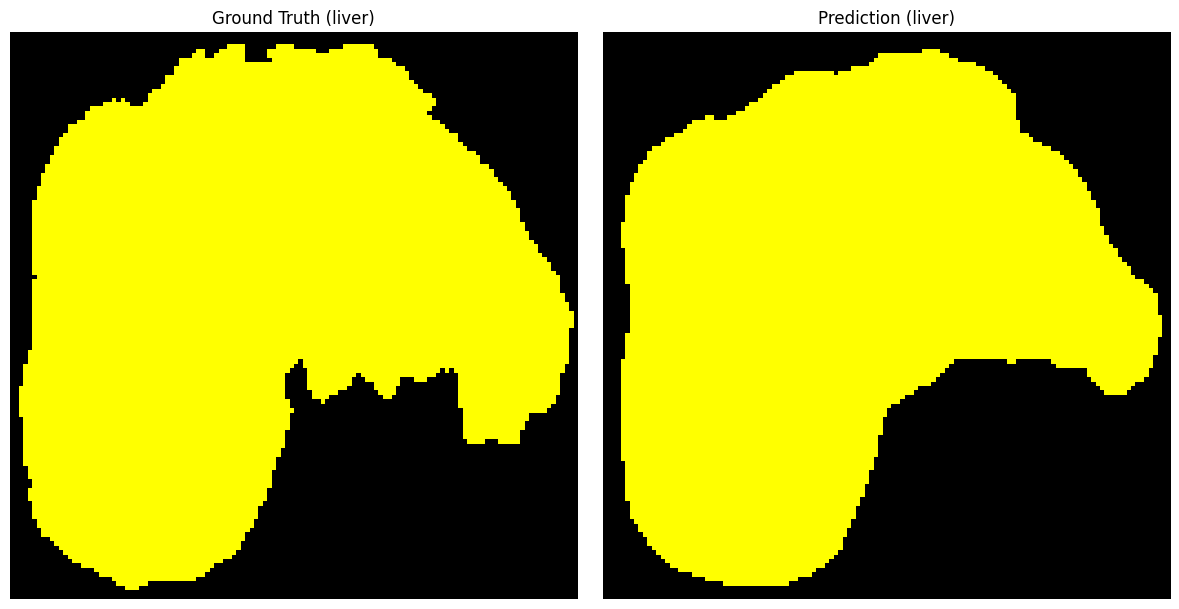

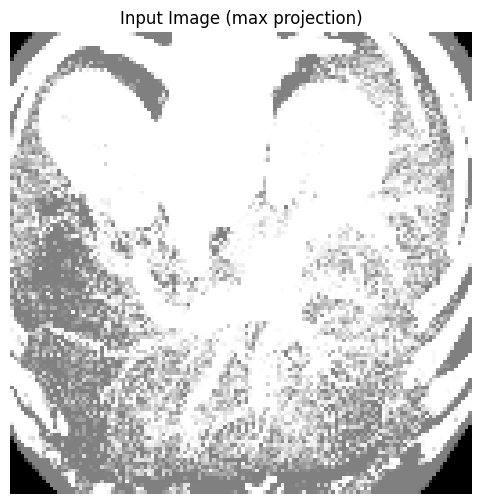

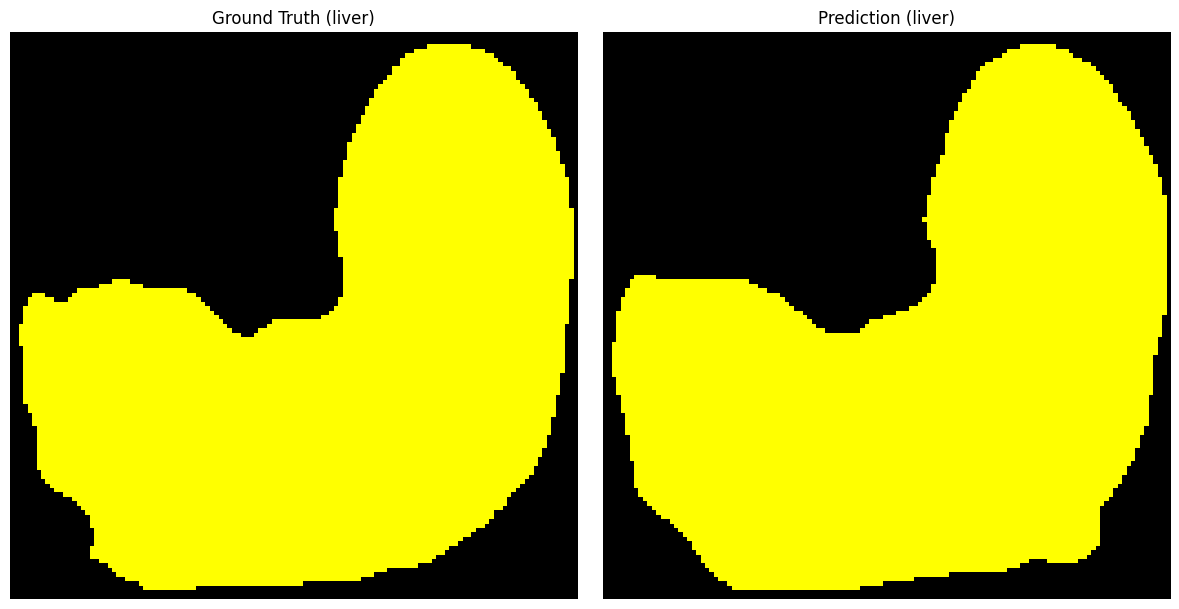

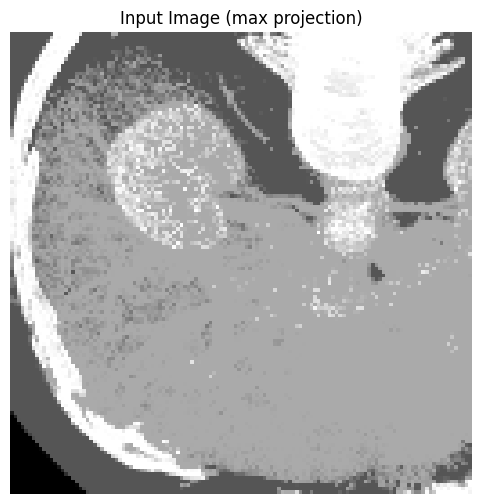

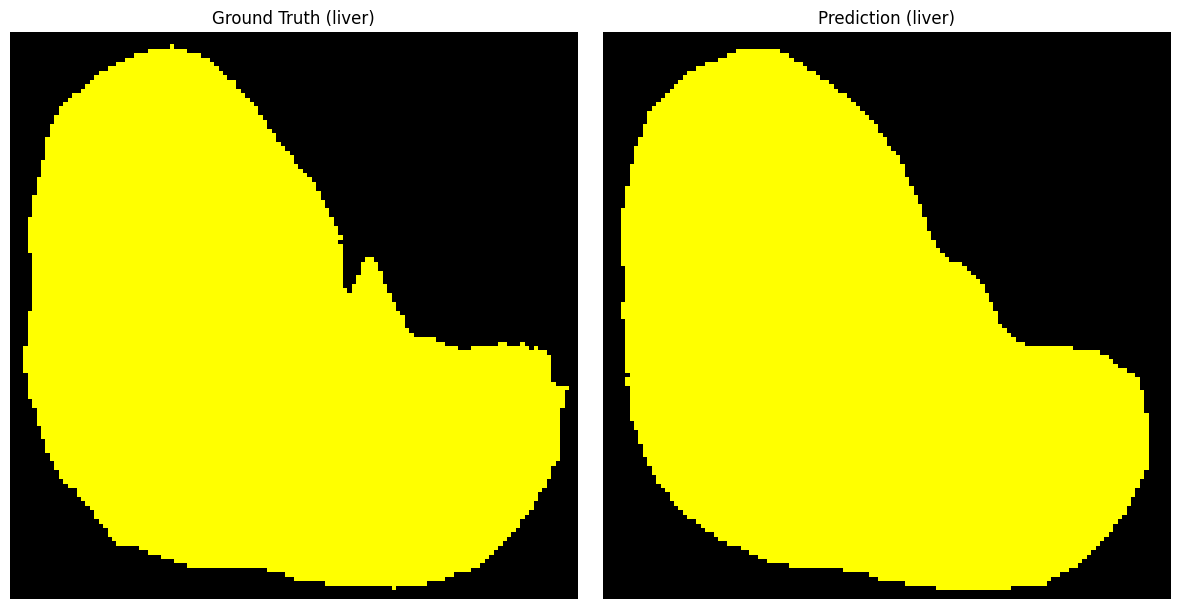

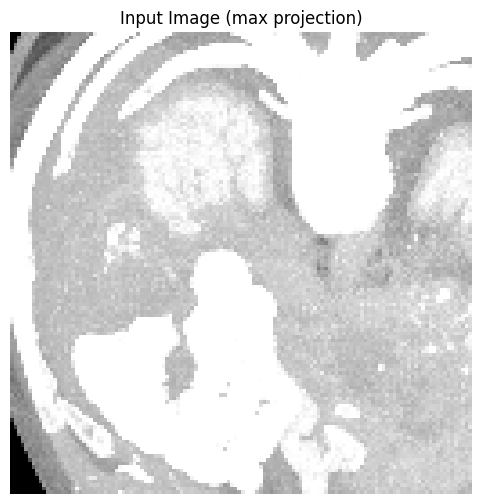

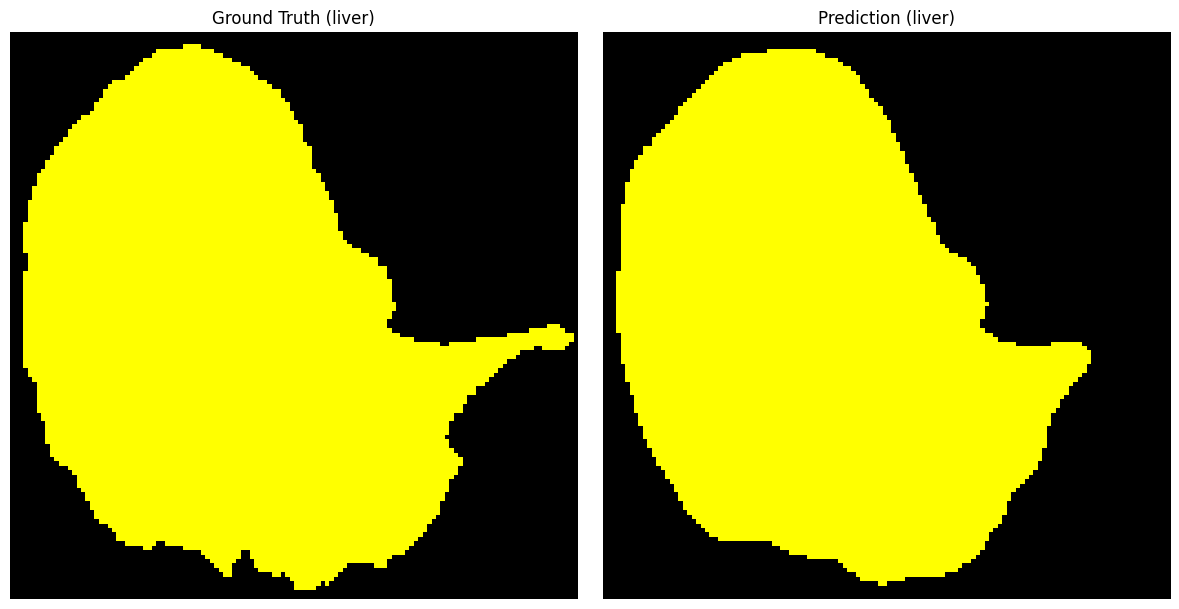

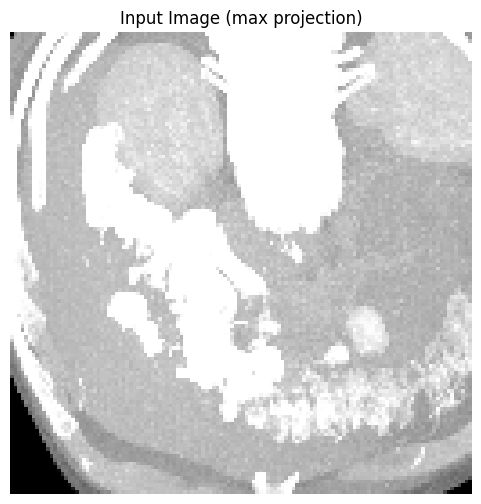

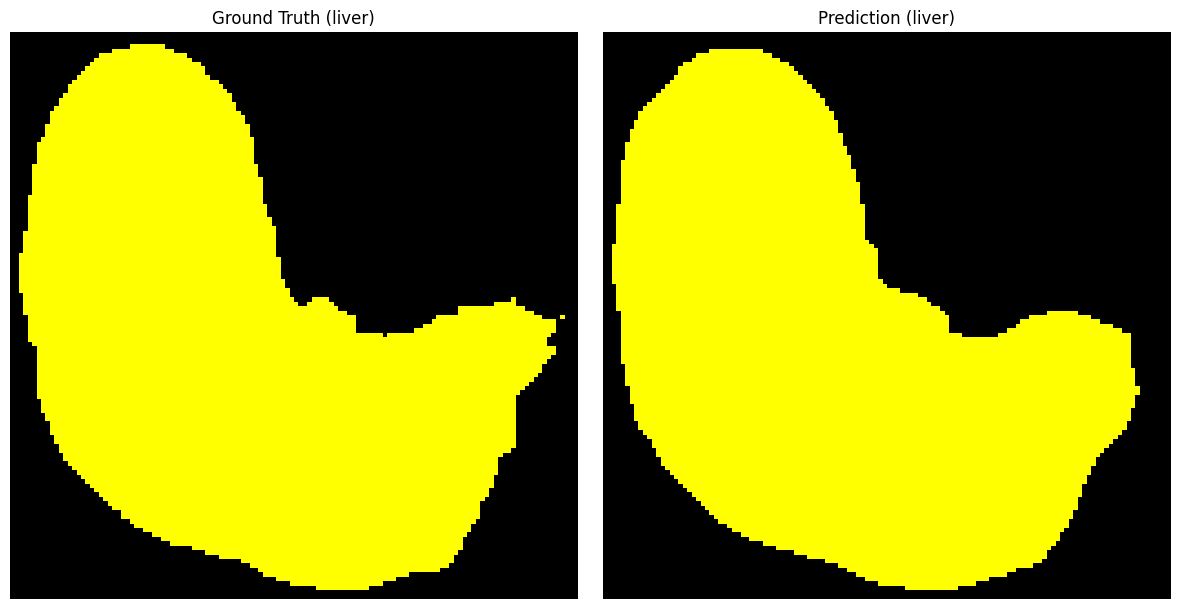

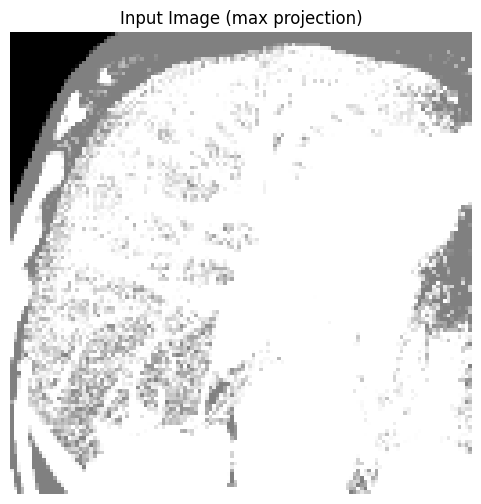

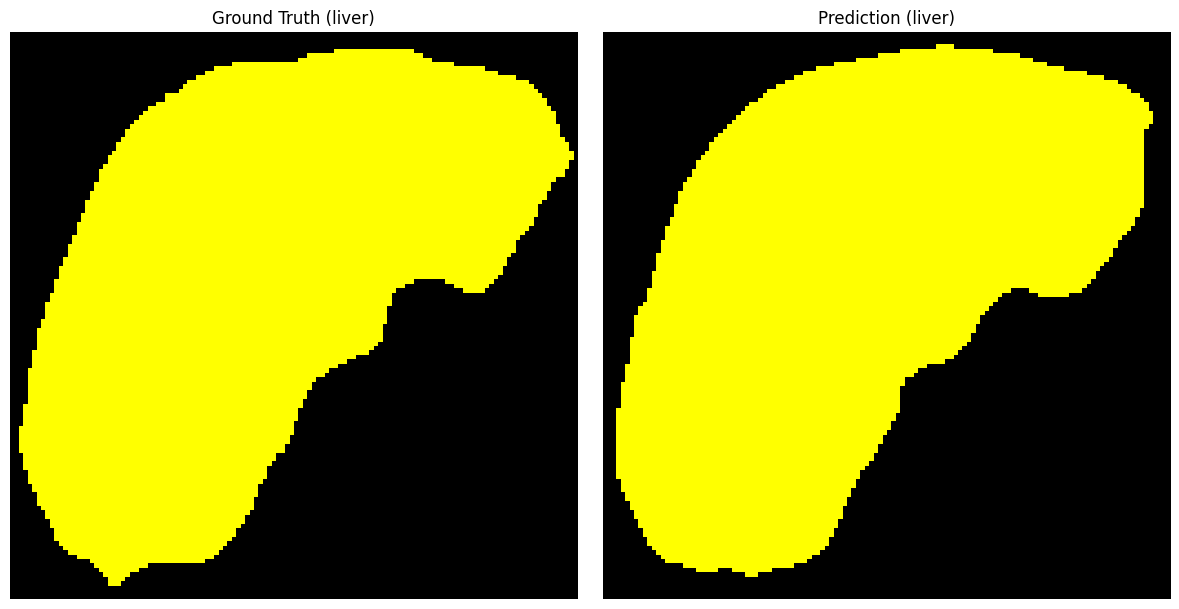

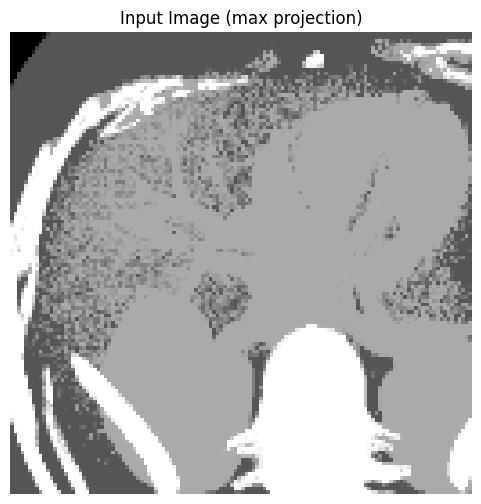

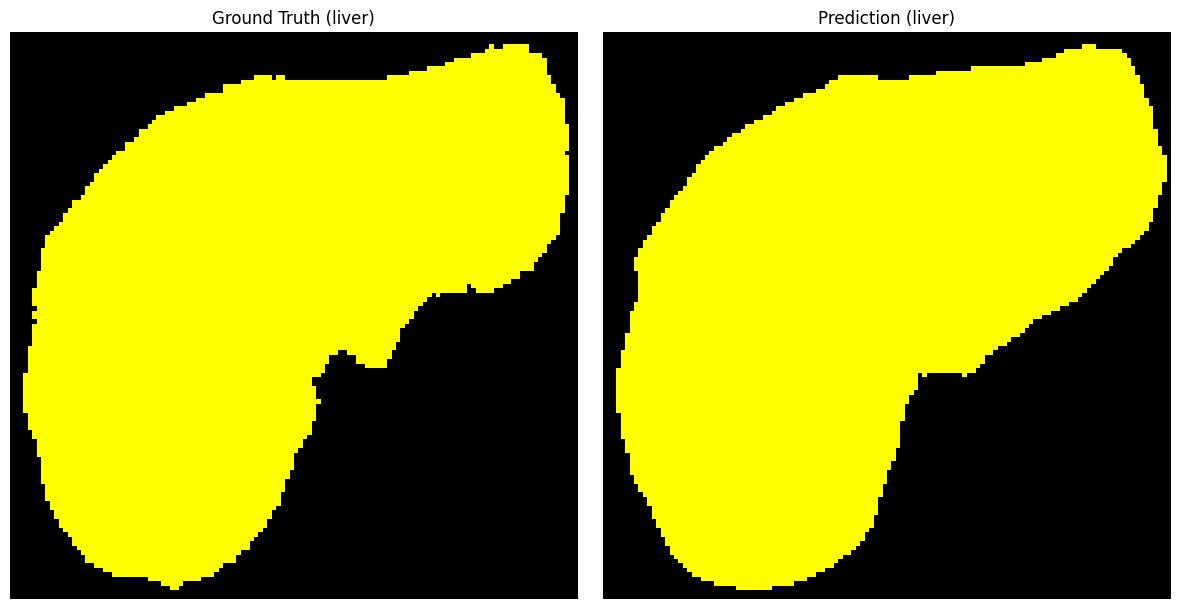

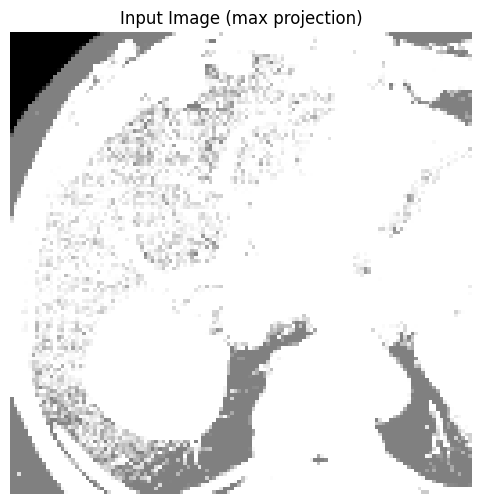

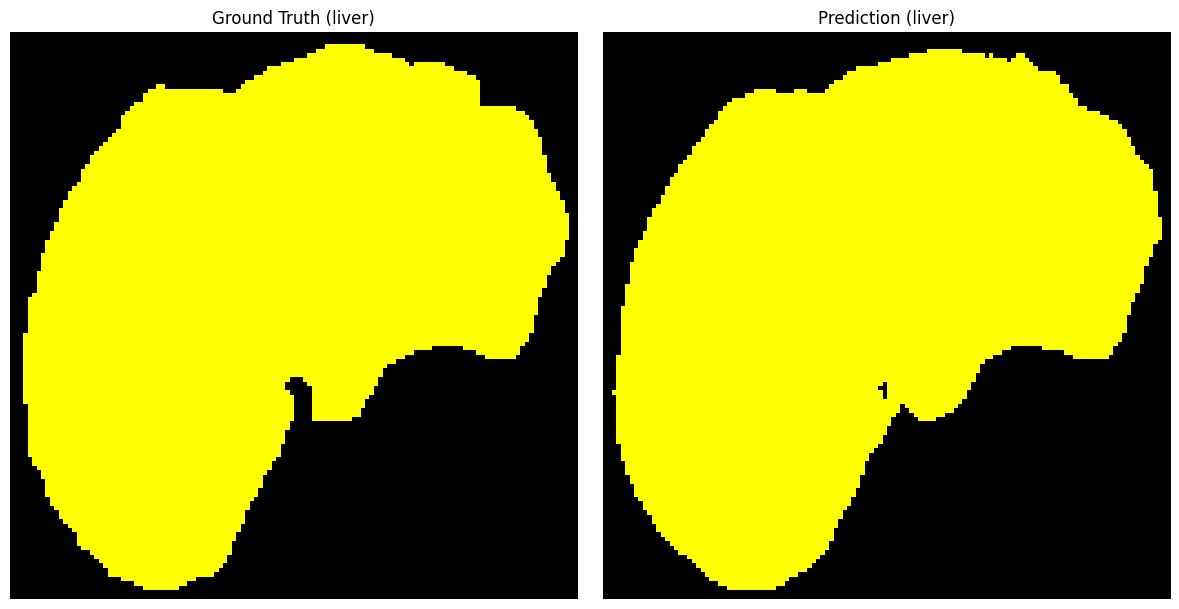

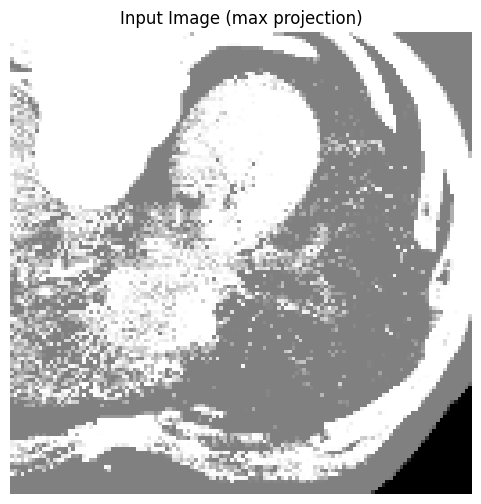

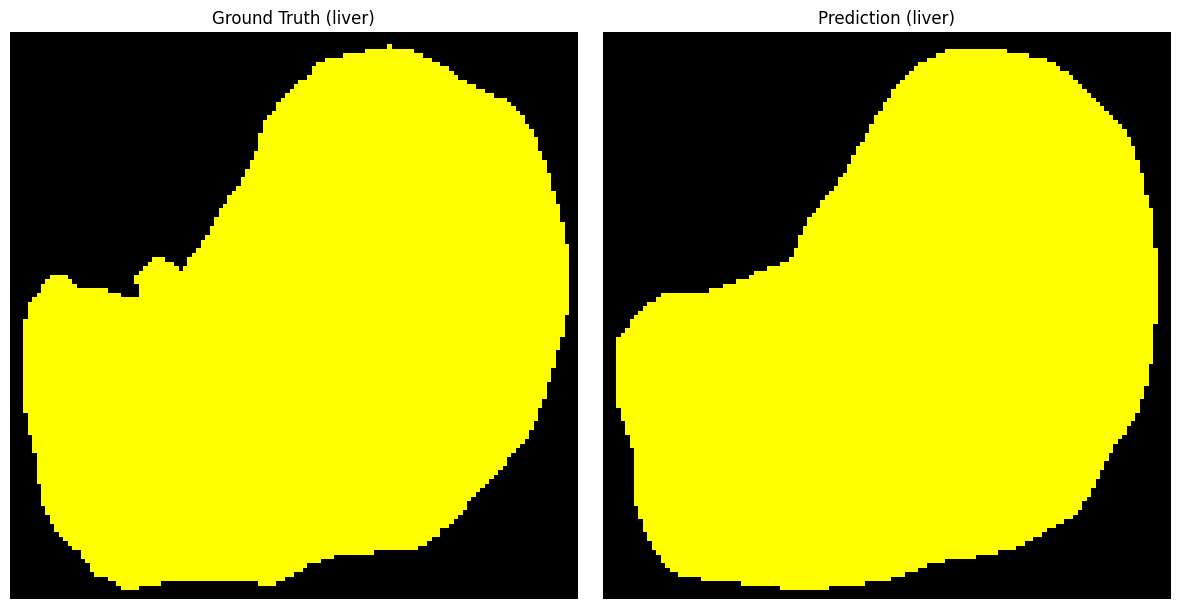

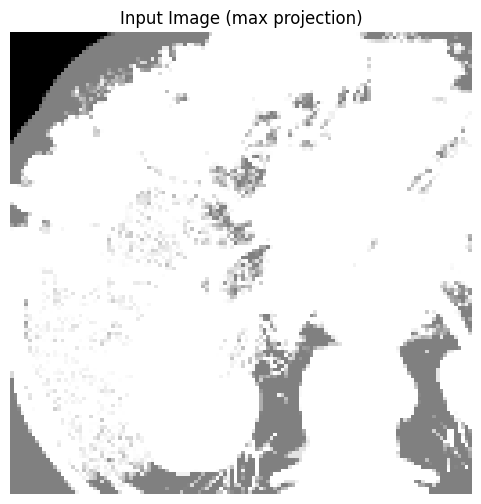

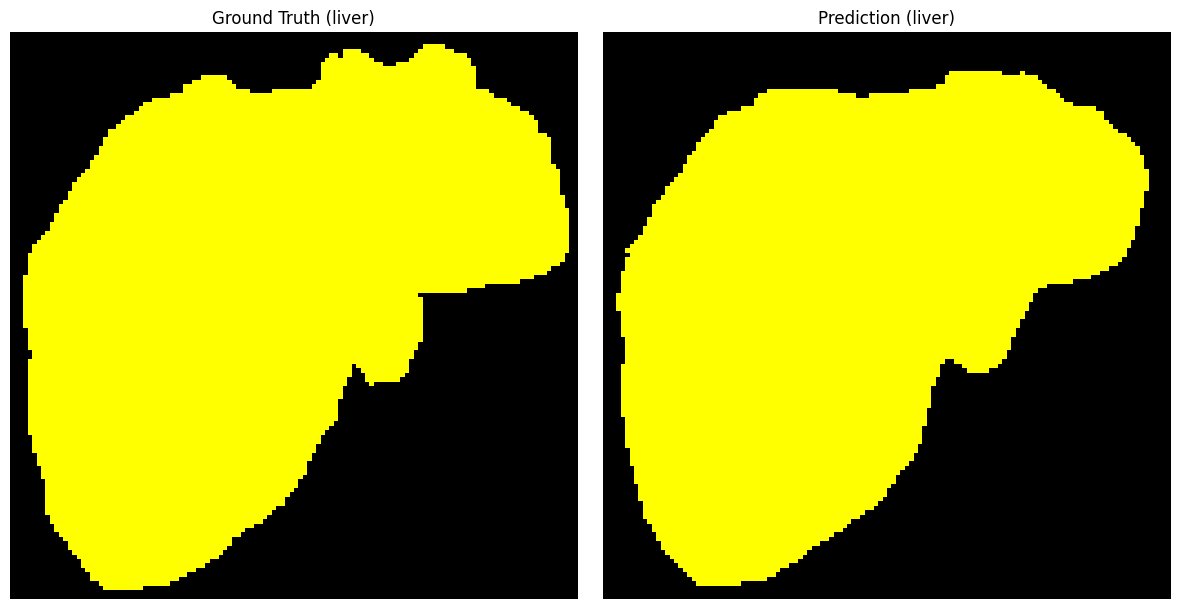

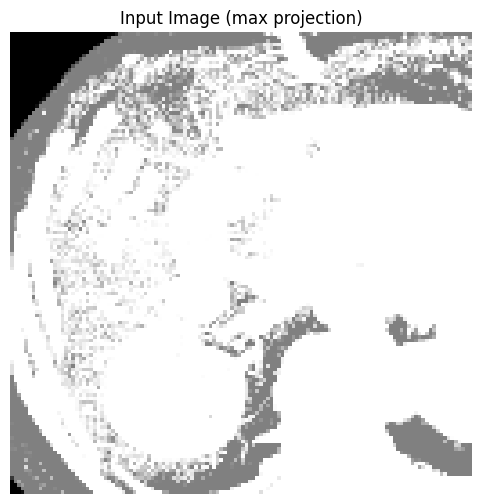

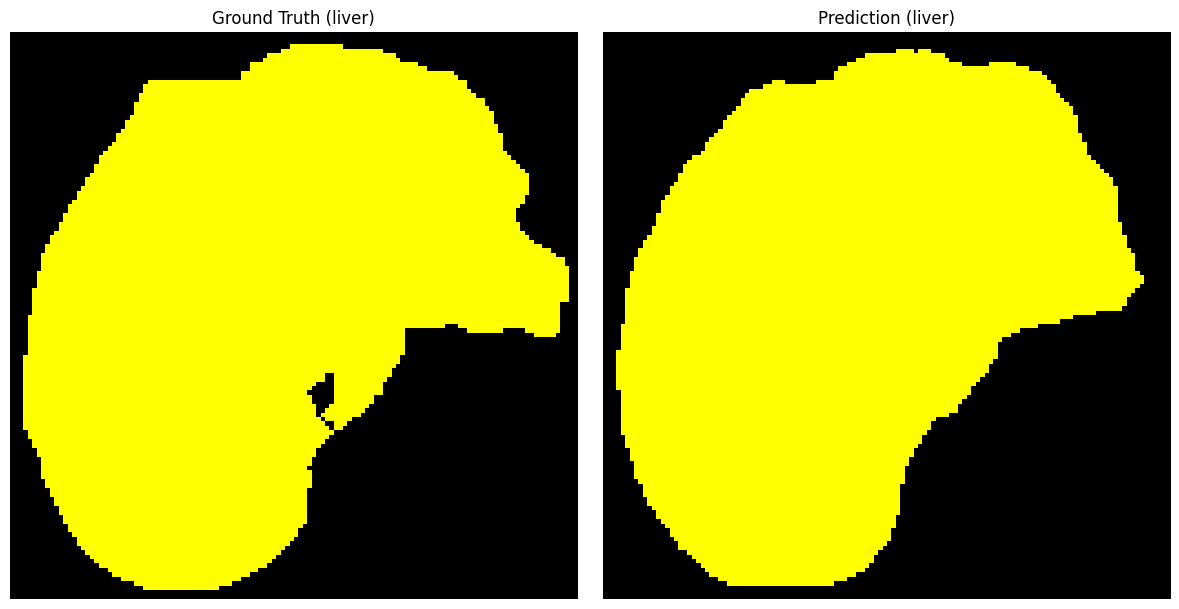

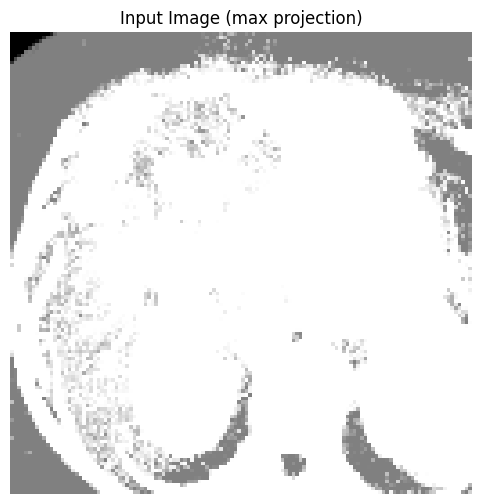

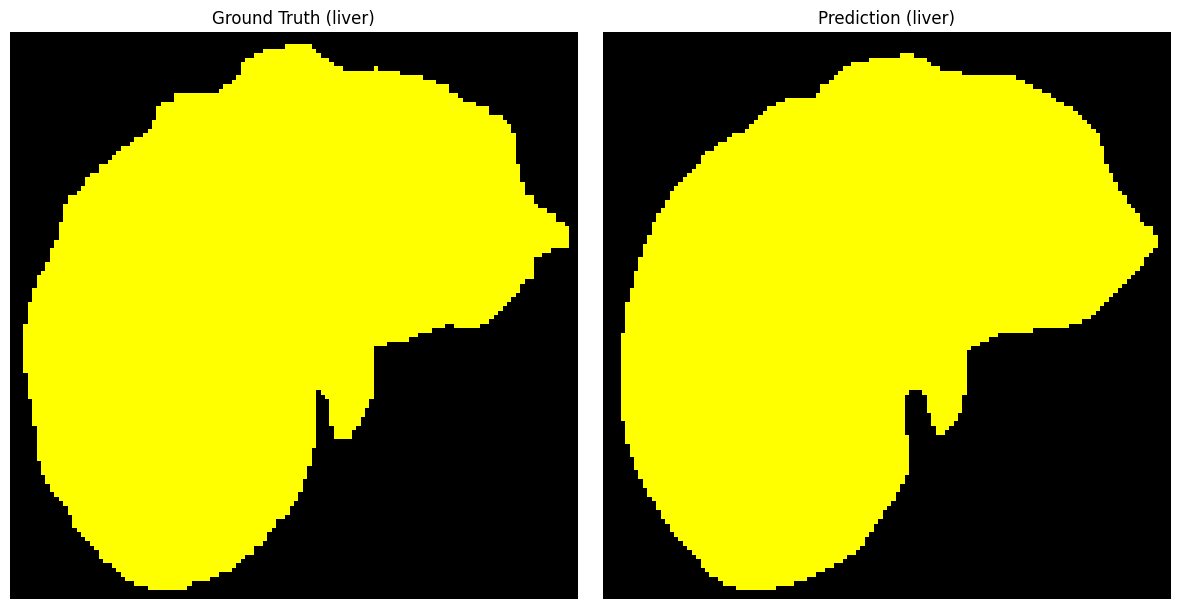

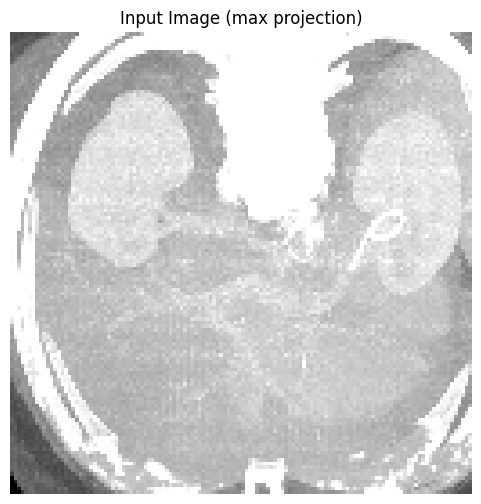

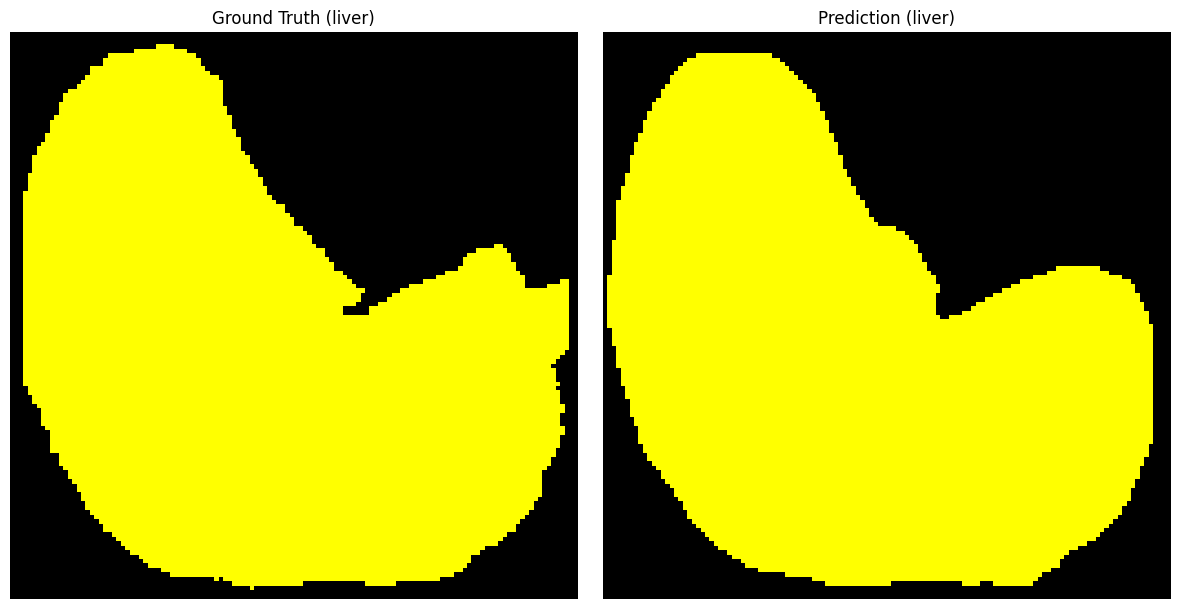

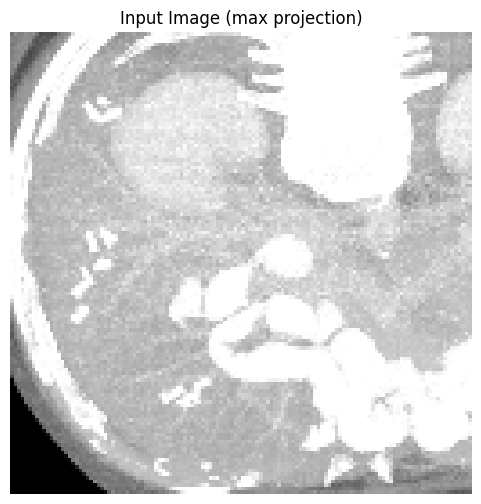

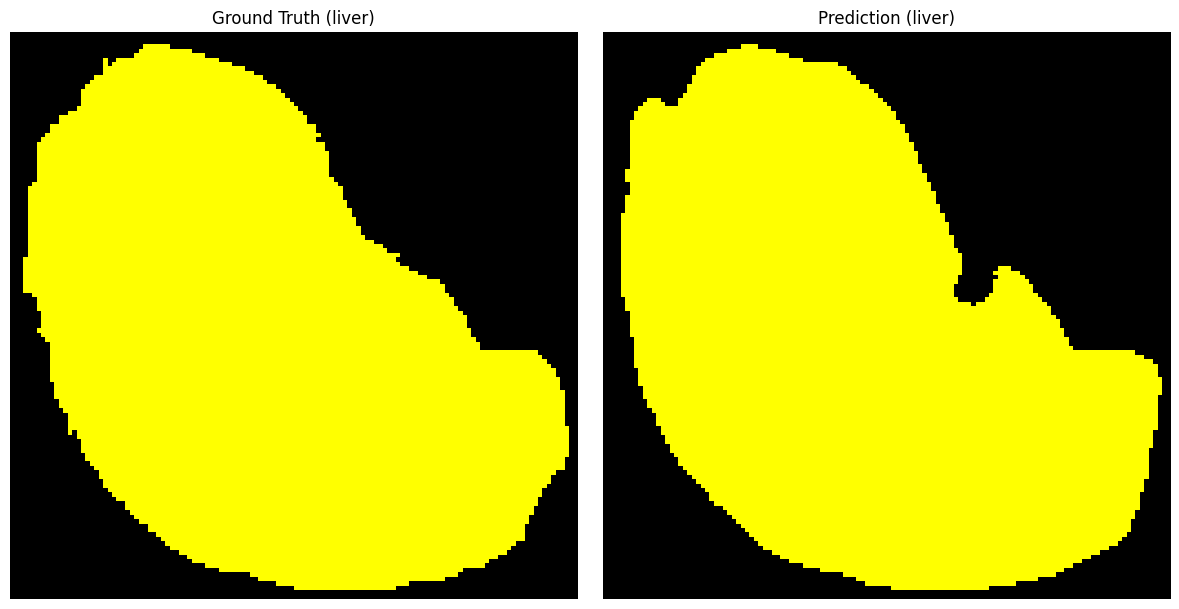

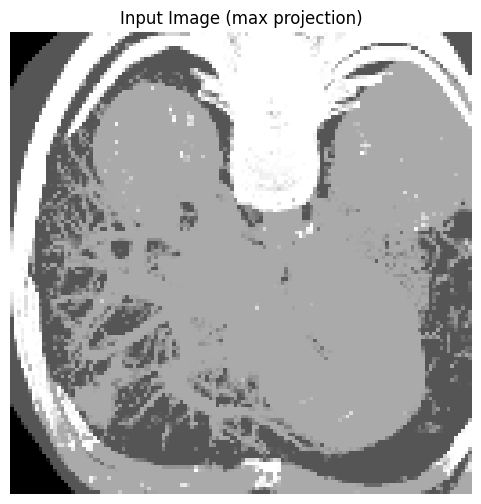

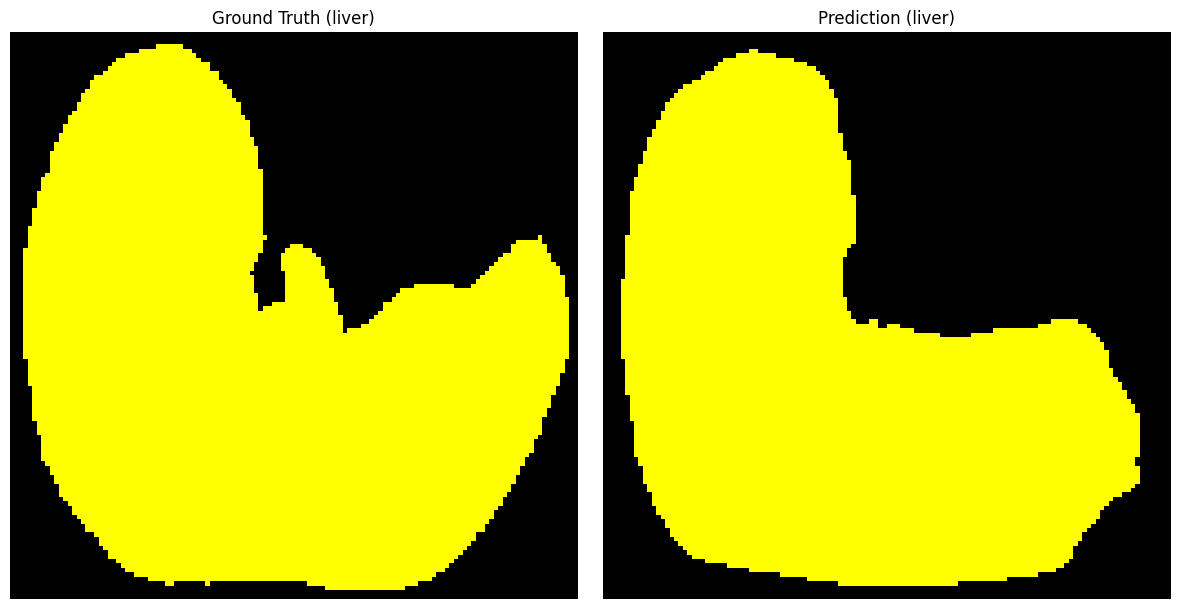

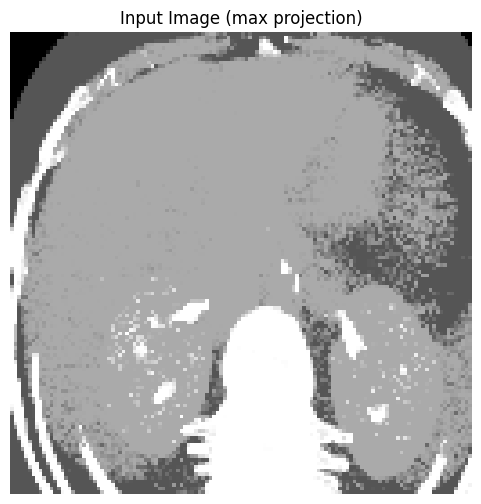

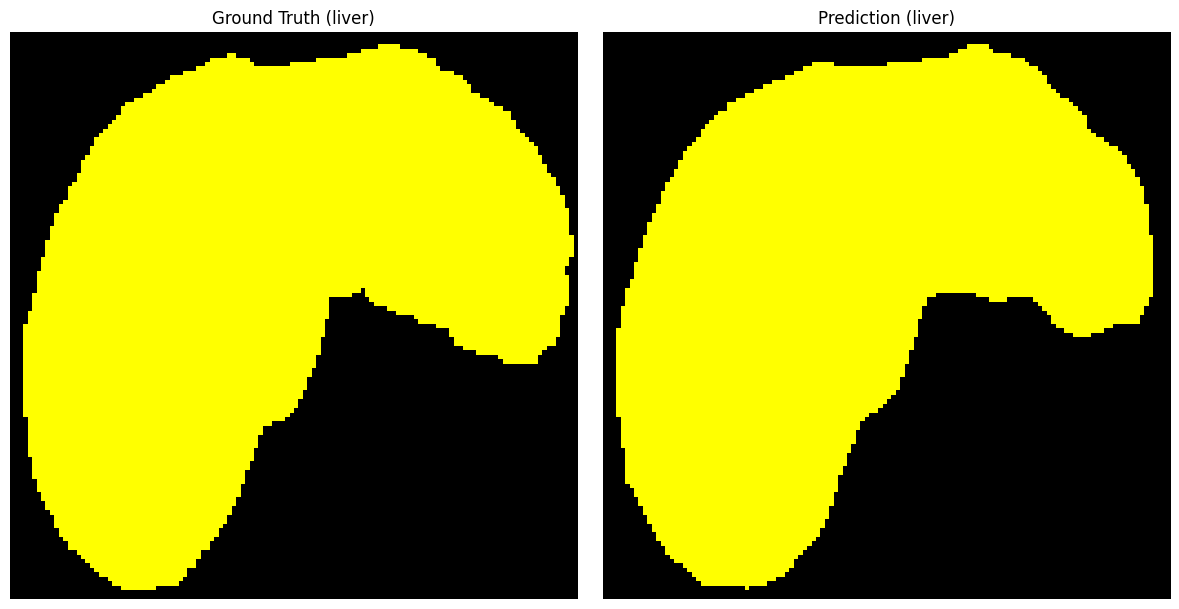

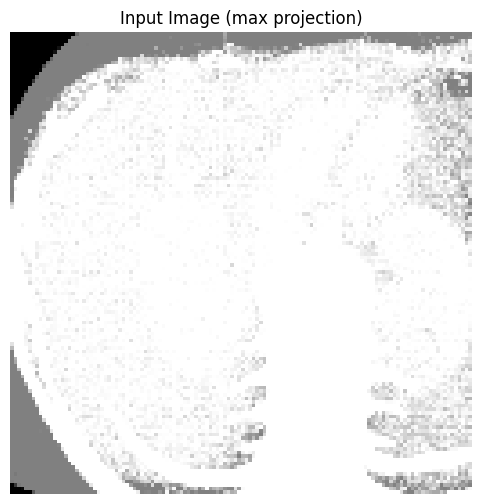

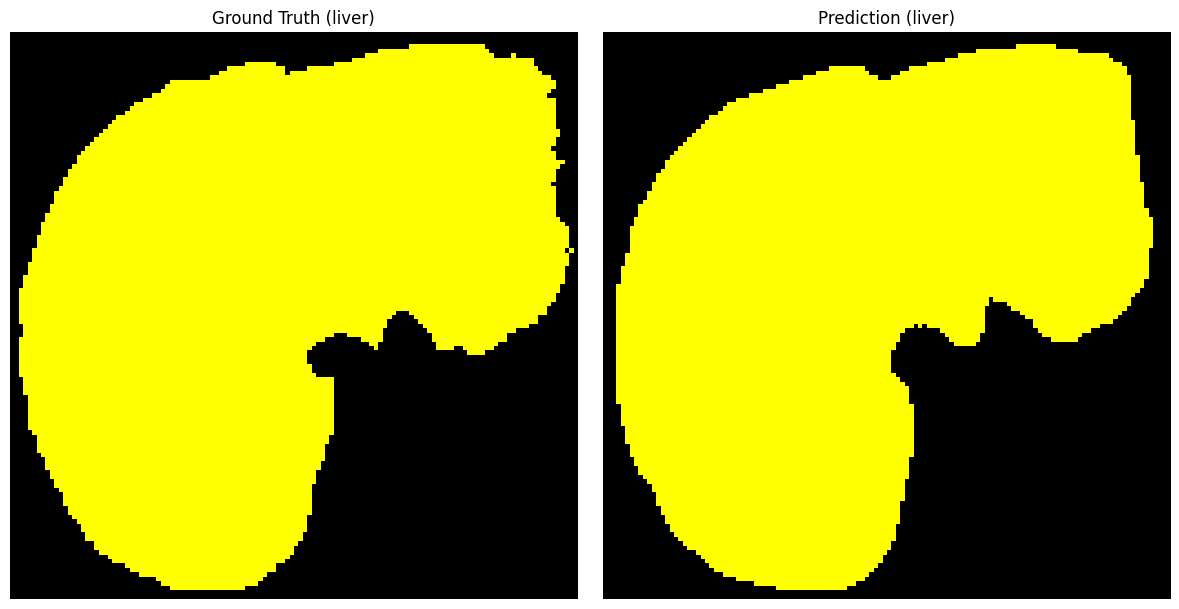

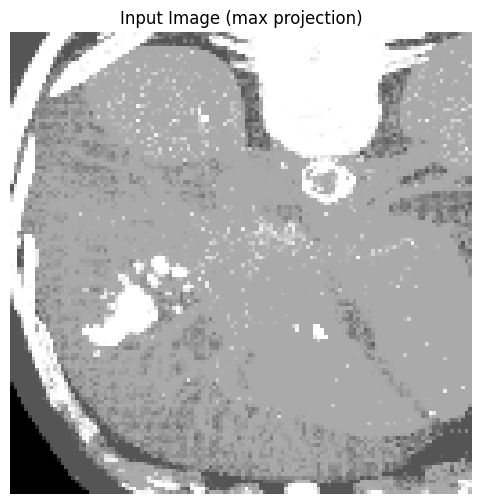

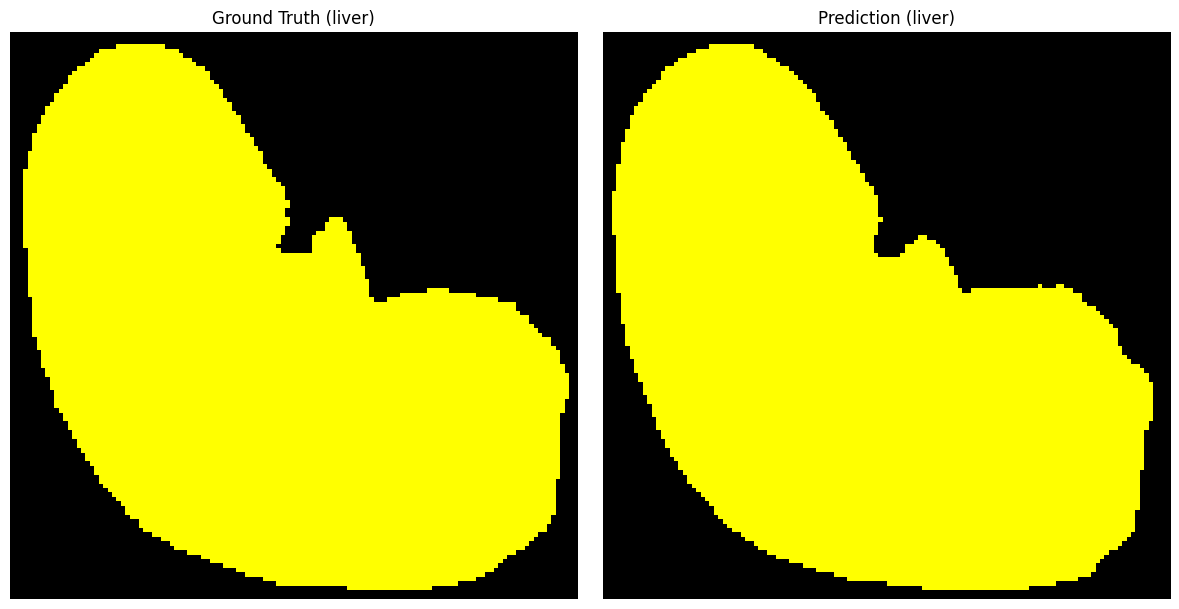

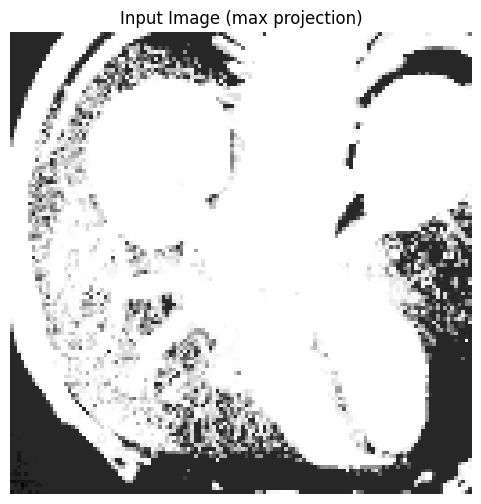

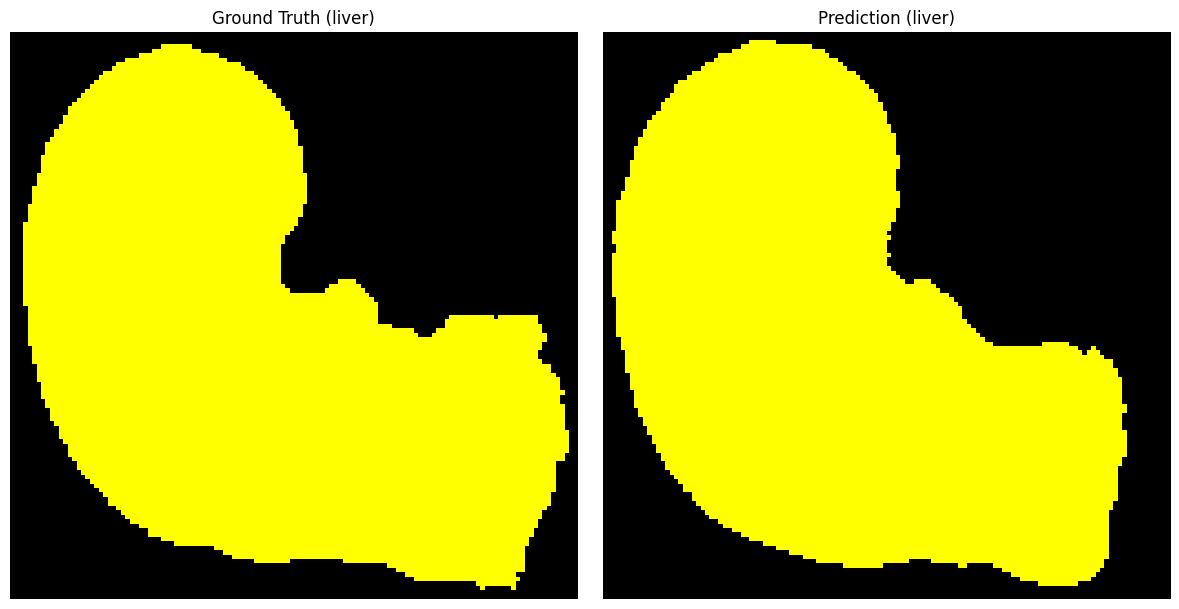

In [ ]:
num_images = len(val_loader)
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/drive/MyDrive/KLTN/code/result_model_*.json"))

['/content/drive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [ ]:
model_results = load_metrics('/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json')

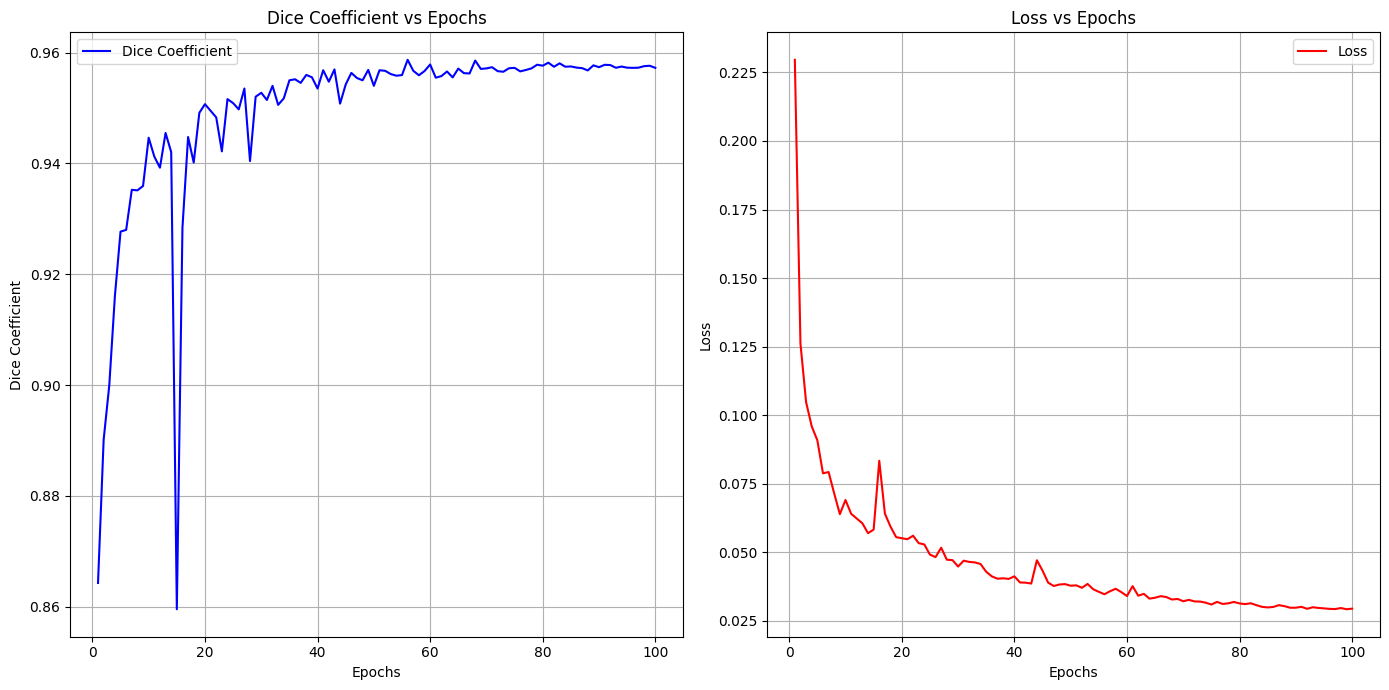

In [ ]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()